# Analyzing CMIP6 Precipitation Statistics Using Percentiles

## packages

In [9]:
# imports
import numpy as np
import xarray as xr
import dask.array as da
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib.lines import Line2D
from matplotlib import cm
from matplotlib import colors
import warnings
warnings.filterwarnings('ignore')

# my lib
from importlib import reload
import cmip6_lib

In [2]:
# if you changed something in cmip6_lib.py
reload(cmip6_lib)

<module 'cmip6_lib' from '/export/data1/hgpeterson/ResearchSchneider/cmip_analysis/cmip6_lib.py'>

## run functions

In [3]:
"""
    precip, precip_pctls, precip_pctls_boot = get_precip_pctls(dfiles, pctls, timeslice, latslice, lonslice)
"""
def get_precip_pctls(dfiles, pctls, timeslice, latslice, lonslice):
    # using open_mfdataset for multiple files
    ds = xr.open_mfdataset(dfiles)
    pr = ds["pr"] # this is precipitation flux in units of kg m-2 s-1

    # convert to precipitation
    dt = 24*60*60  # 24 hours
    rho = 1e3      # density of water in kg m^-3
    m_to_mm = 1e3  # convert meters to milimeters
    precip = m_to_mm*pr*dt/rho # units of mm during 24 hrs
    
    # time and space slice
    if latslice == "extrop":
        precip = precip.sel(time=timeslice, lon=lonslice).where(np.abs(precip.lat) >= 30, drop=True)
    else:
        precip = precip.sel(time=timeslice, lat=latslice, lon=lonslice)
    
    # weight by cos(ϕ)
    weights = da.ones_like(precip)
    cosϕ = np.cos(np.deg2rad(precip.lat))
    weights *= np.tile(cosϕ, (len(precip.lon), 1)).T
    precip *= weights
    
    # load
    precip = precip.values
    
    # compute pctls
    precip_pctls = np.percentile(precip, 100*pctls, interpolation="linear")
    
    # bootstrap indices
    datasize = precip.shape[0]
    samplesize = datasize
    blocksize = 10 # lagrangian decorrelation time ~ 10 days
    nboot = 200
    bootstrap_indices = cmip6_lib.stationary_bootstrap(datasize, samplesize, blocksize, nboot)
    
    # compute pctls of bootstrapped data
    npctls = pctls.shape[0]
    precip_pctls_boot = np.zeros((nboot, npctls))
    for i in range(nboot):
        precip_pctls_boot[i, :] = np.percentile(precip[bootstrap_indices[i, :], :, :], 100*pctls, interpolation="linear")
    
    return precip, precip_pctls, precip_pctls_boot

"""
    precip_c, precip_pctls_c, precip_pctls_boot_c, precip_w, precip_pctls_w, precip_pctls_boot_w, 
    μ_c, σ_c, μ_w, σ_w, ΔT = get_data_ssp585(dfiles, pctls, latslice, lonslice)
"""
def get_data_ssp585(dfiles, pctls, latslice, lonslice):
    # control: first 20 years
    print("computing control pctls.")
    timeslice = slice("2015", "2035")
    precip_c, precip_pctls_c, precip_pctls_boot_c = get_precip_pctls(dfiles, pctls, timeslice, latslice, lonslice)

    # warming: last 20 years
    print("computing warming pctls")
    timeslice = slice("2080", "2100")
    precip_w, precip_pctls_w, precip_pctls_boot_w = get_precip_pctls(dfiles, pctls, timeslice, latslice, lonslice)
    
    # mean and std
    print("computing mean and std")
    μ_c, σ_c = get_mean_std(precip_c)
    μ_w, σ_w = get_mean_std(precip_w)
    
    # temp change
    print("computing temp change")
    if "KACE" in dfiles: # could only get monthly data from KACE model
        ΔT = cmip6_lib.get_ΔT(dfiles.replace("pr_day", "tas_Amon"), latslice, lonslice)
    else:
        ΔT = cmip6_lib.get_ΔT(dfiles.replace("pr_day", "tas_day"), latslice, lonslice)
    
    return precip_c, precip_pctls_c, precip_pctls_boot_c, precip_w, precip_pctls_w, precip_pctls_boot_w, μ_c, σ_c, μ_w, σ_w, ΔT

"""
save_data_ssp585(filename, pctls, precip_pctls_c, precip_pctls_boot_c, precip_pctls_w, precip_pctls_boot_w, 
                     μ_c, σ_c, μ_w, σ_w, ΔT)
"""
def save_data_ssp585(filename, pctls, precip_pctls_c, precip_pctls_boot_c, precip_pctls_w, precip_pctls_boot_w, 
                     μ_c, σ_c, μ_w, σ_w, ΔT):
    np.savez(filename, pctls=pctls, precip_pctls_c=precip_pctls_c, precip_pctls_boot_c=precip_pctls_boot_c,
             precip_pctls_w=precip_pctls_w, precip_pctls_boot_w=precip_pctls_boot_w, 
             μ_c=μ_c, σ_c=σ_c, μ_w=μ_w, σ_w=σ_w, ΔT=ΔT)
    print(filename)
    
"""
    pctls, precip_pctls_c, precip_pctls_boot_c, precip_pctls_w, precip_pctls_boot_w, μ_c, σ_c, μ_w, σ_w, ΔT = load_data_ssp585(filename)
"""
def load_data_ssp585(filename):
    data = np.load(filename)
    pctls = data["pctls"]
    precip_pctls_c = data["precip_pctls_c"]
    precip_pctls_boot_c = data["precip_pctls_boot_c"]
    precip_pctls_w = data["precip_pctls_w"]
    precip_pctls_boot_w = data["precip_pctls_boot_w"]
    μ_c = data["μ_c"]
    σ_c = data["σ_c"]
    μ_w = data["μ_w"]
    σ_w = data["σ_w"]
    ΔT = data["ΔT"]
    return pctls, precip_pctls_c, precip_pctls_boot_c, precip_pctls_w, precip_pctls_boot_w, μ_c, σ_c, μ_w, σ_w, ΔT

## compute percentiles for each model

In [4]:
# lat slice
latslice = slice(-90, 90)
# latslice = slice(-30, 30)
# latslice = "extrop"

# lon slice
lonslice = slice(0, 360)

# model descriptions
variable_name = "pr"
frequency_value = "day"
experiment_id = "ssp585"
variant_label = "r1i1p1f1"
if latslice == slice(-90, 90):
    domain = ""
elif latslice == slice(-30, 30):
    domain = "trop_"
elif latslice == "extrop":
    domain = "extrop_"
print(domain)

# folder
path = "/export/data1/hgpeterson/cmip6/" + variable_name + "_" + frequency_value + "_" + experiment_id + "/"

# make an array of source_id's and grid_label's to choose from
file_list = cmip6_lib.get_file_list(path)

In [ ]:
# loop through models
for [source_id, grid_label] in file_list:
    # get file names structure
    filenames = variable_name + "_" + frequency_value + "_" + source_id + "_" + experiment_id + "_" + variant_label + "_" + grid_label + "_*.nc"
    dfiles = path + filenames
    print("\n" + filenames)

    precip_c, precip_pctls_c, precip_pctls_boot_c, precip_w, precip_pctls_w, precip_pctls_boot_w, μ_c, σ_c, μ_w, σ_w, ΔT = get_data_ssp585(dfiles, pctls, latslice, lonslice)    

    savefile = "data/pctls_{}{}.npz".format(domain, filenames[:-5])
    save_data_ssp585(savefile, pctls, precip_pctls_c, precip_pctls_boot_c, precip_pctls_w, precip_pctls_boot_w, μ_c, σ_c, μ_w, σ_w, ΔT)

## plots

In [5]:
# order file_list by ΔT
ΔTs = np.zeros(len(file_list))
i = 0
for [source_id, grid_label] in file_list: 
    # get file names structure
    fbase = variable_name + "_" + frequency_value + "_" + source_id + "_" + experiment_id + "_" + variant_label + "_" + grid_label
    filename = "data/pctls_" + fbase # global

    pctls, precip_pctls_c, precip_pctls_boot_c, precip_pctls_w, precip_pctls_boot_w, μ_c, σ_c, μ_w, σ_w, ΔT = load_data_ssp585(filename + ".npz")
    ΔTs[i] = ΔT
    
    i += 1

file_list_sorted = file_list[np.argsort(ΔTs), :]

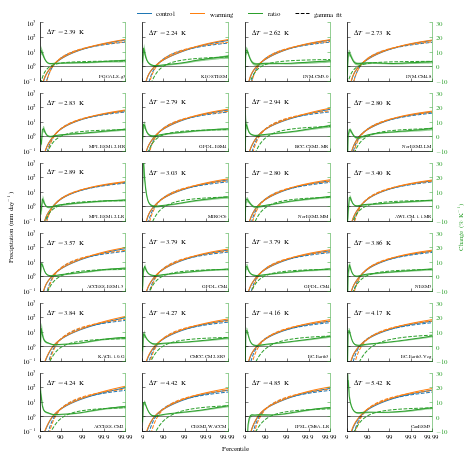

In [10]:
### postage stamps!
nrows = 6
ncols = 4
fig, axes = plt.subplots(nrows, ncols, figsize=(3.404*2, 3.404*2/ncols/1.62*nrows), sharex=True, sharey=True)

i = 0
for [source_id, grid_label] in file_list_sorted: 
    # iterate to next subplot
    ax = axes.flatten()[i]
    
    # get file names structure
    fbase = variable_name + "_" + frequency_value + "_" + source_id + "_" + experiment_id + "_" + variant_label + "_" + grid_label
    filename = "data/pctls_" + domain + fbase    
    filename_global = "data/pctls_" + fbase

    pctls, precip_pctls_c, precip_pctls_boot_c, precip_pctls_w, precip_pctls_boot_w, μ_c, σ_c, μ_w, σ_w, ΔT_global = load_data_ssp585(filename_global + ".npz")
    pctls, precip_pctls_c, precip_pctls_boot_c, precip_pctls_w, precip_pctls_boot_w, μ_c, σ_c, μ_w, σ_w, ΔT = load_data_ssp585(filename + ".npz")

    # means and standard deviations from pdfs
    mean_scaling = μ_w/μ_c - 1

    # fits
    k_c, θ_c = cmip6_lib.gamma_moments(μ_c, σ_c)
    k_w, θ_w = cmip6_lib.gamma_moments(μ_w, σ_w)

    # warming fit based on theory
    extreme_scaling = precip_pctls_w[-1]/precip_pctls_c[-1] - 1
    θ_w_theory = θ_c*(1 + extreme_scaling)
    k_w_theory = k_c*(1 + mean_scaling - extreme_scaling)

    axtwin = cmip6_lib.pctl_plot(ax, ΔT_global, pctls, precip_pctls_c, precip_pctls_boot_c, k_c, θ_c, precip_pctls_w, precip_pctls_boot_w, k_w_theory, θ_w_theory)
    
    # temp change 
    ax.annotate("$\Delta T = {:1.2f}$ K".format(ΔT), (0.08, 0.8), xycoords="axes fraction")
    
    # add model label 
    ax.annotate(source_id, (0.99, 0.07), xycoords="axes fraction", ha="right", size=5)
    
    # labels depending on subplot position
    if (i + 1) % ncols != 0:
        axtwin.set_yticklabels([])

    if i == 3:
        axtwin.set_ylabel("Change (\% K$^{-1}$)", c="tab:green")
        axtwin.yaxis.set_label_coords(1.3, -2.5)
    
    if i == 0:
        ax.set_ylabel("Precipitation (mm day$^{-1}$)")
        ax.yaxis.set_label_coords(-0.3, -2.5)
    
    if i == 16:
        ax.set_xlabel("Percentile")
        ax.xaxis.set_label_coords(2.3, -1.45)
        
    if i == 0:
        custom_lines = [Line2D([0], [0], ls="-", c="tab:blue"),
                       Line2D([0], [0], ls="-", c="tab:orange"),
                       Line2D([0], [0], ls="-", c="tab:green"),
                       Line2D([0], [0], ls="--", c="k")]
        custom_handles = ["control", "warming", "ratio", "gamma fit"]
        ax.legend(custom_lines, custom_handles, ncol=4, loc=(1.1, 1.05))
        
    i += 1

# plt.tight_layout()
plt.subplots_adjust(bottom=0.05, top=0.95, left=0.1, right=0.9, wspace=0.2, hspace=0.2)
plt.savefig("pdfs_{}pctl_theory.png".format(domain))
plt.savefig("pdfs_{}pctl_theory.pdf".format(domain))


trop_
extrop_


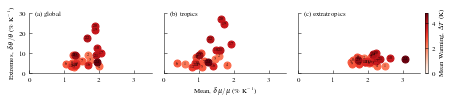

In [7]:
### scatter plots

# init plot
nrows = 1
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(3.404*2, 3.404*2/ncols/1.62*nrows), sharey=True)
axes[0].set_ylabel("Extremes, $\\delta\\theta/\\theta$ (\% K$^{-1}$)")
axes[1].set_xlabel("Mean, $\\delta\\mu/\\mu$ (\% K$^{-1}$)")
axes[0].annotate("(a) global", (0.05, 0.95), xycoords="axes fraction")
axes[1].annotate("(b) tropics", (0.05, 0.95), xycoords="axes fraction")
axes[2].annotate("(c) extratropics", (0.05, 0.95), xycoords="axes fraction")

# colors based on ΔT
ΔTs_normalized = np.sort(ΔTs)/np.max(ΔTs)
cs = pl.cm.Reds(ΔTs_normalized)

# loop
i = 0
for domain in ["", "trop_", "extrop_"]:
    print(domain)
    ax = axes[i]
    ax.set_xlim([0, 3.5])
    ax.set_ylim([0, 30])
    j = 0
    for [source_id, grid_label] in file_list_sorted:     
        # get file names structure
        fbase = variable_name + "_" + frequency_value + "_" + source_id + "_" + experiment_id + "_" + variant_label + "_" + grid_label
        filename = "data/pctls_" + domain + fbase    
        filename_global = "data/pctls_" + fbase
        
        # get data
        pctls, precip_pctls_c, precip_pctls_boot_c, precip_pctls_w, precip_pctls_boot_w, μ_c, σ_c, μ_w, σ_w, ΔT_global = load_data_ssp585(filename_global + ".npz")            
        pctls, precip_pctls_c, precip_pctls_boot_c, precip_pctls_w, precip_pctls_boot_w, μ_c, σ_c, μ_w, σ_w, ΔT = load_data_ssp585(filename + ".npz")
        
        # compute scalings
        mean_scaling = μ_w/μ_c - 1
        extreme_scaling = precip_pctls_w[-1]/precip_pctls_c[-1] - 1
#         extreme_scaling = np.mean(precip_pctls_w[np.where(pctls > 0.999)]/precip_pctls_c[np.where(pctls > 0.999)] - 1)

        # plot
        ax.plot(100*mean_scaling/ΔT_global, 100*extreme_scaling/ΔT_global, marker="o", ls="", c=cs[j, :],
               markersize=7, zorder=1)
        ax.annotate(j + 1, (100*mean_scaling/ΔT_global, 100*extreme_scaling/ΔT_global), xycoords="data", ha="center", va="center", size=4, zorder=2)
        j += 1
    i += 1
    
plt.subplots_adjust(bottom=0.3, top=0.9, left=0.1, right=1.05, wspace=0.1, hspace=0.1)
plt.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=np.max(ΔTs)), cmap="Reds"), ax=axes, label=r"Mean Warming, $\Delta T$ (K)", pad=0.01)
plt.savefig("scalings.png")
plt.savefig("scalings.pdf")

In [8]:
### print table

index = 1
print("No. & Source ID & Grid Label & $\\Delta T$ (K)\\\\")
for [source_id, grid_label] in file_list_sorted:     
    print("{} & {} & {} & {:1.2f}\\\\".format(index, source_id, grid_label, ΔTs[np.argsort(ΔTs)[index-1]]))
    index += 1 

No. & Source ID & Grid Label & $\Delta T$ (K)\\
1 & FGOALS-g3 & gn & 2.18\\
2 & KIOST-ESM & gr1 & 2.18\\
3 & INM-CM5-0 & gr1 & 2.28\\
4 & INM-CM4-8 & gr1 & 2.39\\
5 & MPI-ESM1-2-HR & gn & 2.58\\
6 & GFDL-ESM4 & gr1 & 2.61\\
7 & BCC-CSM2-MR & gn & 2.66\\
8 & NorESM2-LM & gn & 2.66\\
9 & MPI-ESM1-2-LR & gn & 2.67\\
10 & MIROC6 & gn & 2.73\\
11 & NorESM2-MM & gn & 2.75\\
12 & AWI-CM-1-1-MR & gn & 3.00\\
13 & ACCESS-ESM1-5 & gn & 3.23\\
14 & GFDL-CM4 & gr1 & 3.36\\
15 & GFDL-CM4 & gr2 & 3.36\\
16 & NESM3 & gn & 3.41\\
17 & KACE-1-0-G & gr & 3.63\\
18 & CMCC-CM2-SR5 & gn & 3.68\\
19 & EC-Earth3 & gr & 3.69\\
20 & EC-Earth3-Veg & gr & 3.71\\
21 & ACCESS-CM2 & gn & 3.94\\
22 & CESM2-WACCM & gn & 4.02\\
23 & IPSL-CM6A-LR & gr & 4.31\\
24 & CanESM5 & gn & 4.80\\
